In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import cv2
import torch
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import ParameterGrid

In [2]:
#!pip3 install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [3]:
'''
!pip install openmim
!mim install mmdet
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -q -e .
!wget https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
'''
pass

In [4]:
#%%bash
#export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/opt/conda/lib/python3.7/site-packages/torch/lib/

In [5]:
df = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
a = 1
b = 50

ret1 = np.sqrt(((df['Pawpularity'] - a) ** 2).mean())
ret2 = np.sqrt(((df['Pawpularity'] - b) ** 2).mean())

A = np.array([[1, -2 * a],
              [1, -2 * b]])
r = np.array([ret1 ** 2 - a ** 2, ret2 ** 2 - b ** 2])
m2, m = np.linalg.solve(A, r)
v = m2 - m ** 2
m, v, np.sqrt(v)

(38.03904358353511, 423.98727705136935, 20.590951339153065)

In [6]:
1870.9561138 -  (38.03904358 ** 2)

423.98727731886083

In [7]:
np.sqrt( 424.03005651631685)

20.591990105774546

In [8]:
df['Pawpularity'].mean(), df['Pawpularity'].var(), df['Pawpularity'].std()

(38.03904358353511, 424.03005651631685, 20.591990105774546)

In [9]:
a = 1 / 100
b = 50 / 100

ret1 = 42.62250 / 100
ret2 = 23.58385 / 100

A = np.array([[1, -2 * a],
              [1, -2 * b]])
r = np.array([ret1 ** 2 - a ** 2, ret2 ** 2 - b ** 2])
m2, m = np.linalg.solve(A, r)
v = m2 - m ** 2
print('平均、分散、標準偏差')
print(m, v, np.sqrt(v))

平均、分散、標準偏差
0.3836203597375 0.04207557741462112 0.2051233224541303


In [10]:
1892.4015782 -  (38.36203597 ** 2)

420.755774436426

<AxesSubplot:>

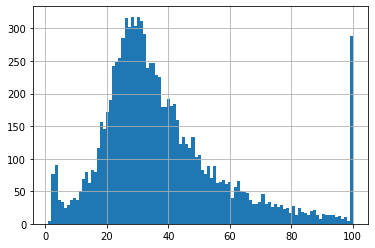

In [11]:
df['Pawpularity'].hist(bins=100)

In [12]:
#df = pd.read_csv('../exps/exp1_swin_large_patch4_window12_384/train_cv_score.csv')
df = pd.read_csv('ens_exp15.csv')

<AxesSubplot:>

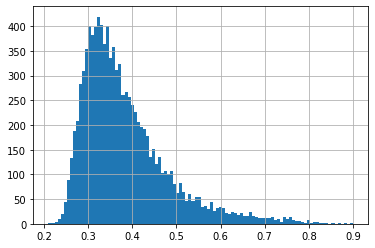

In [13]:
df['pred'].hist(bins=100)

In [14]:
np.sqrt((((df['pred']).clip(0.1, 1) - df['norm_score']) ** 2).mean()) * 100

17.55076839820512

In [15]:
np.sqrt((((df['pred'] / df['pred'].mean() * df['norm_score'].mean()).clip(0.1, 1) - df['norm_score']) ** 2).mean()) * 100

17.527578134722287

In [16]:
np.sqrt(((np.where(df['pred'] > 0.8, 1, df['pred']) - df['norm_score']) ** 2).mean()) * 100

17.584814544417977

In [17]:
df['Pawpularity'].value_counts().sort_index(ascending=False)#.cumsum()# / df.shape[0]

99    288
98      4
97     10
96      8
95     12
     ... 
4      34
3      36
2      90
1      77
0       4
Name: Pawpularity, Length: 100, dtype: int64

In [18]:
pred = (df['pred'] - df['pred'].mean()) / df['pred'].std()
pred = pred * df['norm_score'].std() + df['norm_score'].mean()
pred = pred.clip(0.1, 1)
np.sqrt(((pred - df['norm_score']) ** 2).mean()) * 100

19.538520137403008

In [19]:
df['norm_score'].mean()

0.3703904358353494

In [20]:
np.sqrt((((df['pred'] - df['pred'].mean() + df['norm_score'].mean()).clip(0.1, 1) - df['norm_score']) ** 2).mean()) * 100

17.503932797997017

In [21]:
sc = np.sort(df['pred'])[::-1]
pred = np.zeros(df.shape[0])
s = 0
for i, v in df['Pawpularity'].value_counts().sort_index(ascending=False).to_frame('cnt').iterrows():
    s += v['cnt'] - 1    
    pred[(df['pred'] > sc[s]) & (pred == 0)] = i / 100


In [22]:
np.sqrt(((pred - df['norm_score']) ** 2).mean()) * 100

20.051411926801535

In [23]:

from mmdet.apis import init_detector, inference_detector
import mmcv

path = df.loc[0, 'path']

# Specify the path to model config and checkpoint file
config_file = 'mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:1')

# test a single image and show the results
img = path  # or img = mmcv.imread(img), which will only load it once
result = inference_detector(model, img)
# visualize the results in a new window
#plt.imshow(model.show_result(img, result))
# or save the visualization results to image files
#model.show_result(img, result, out_file='result.jpg')


load checkpoint from local path: checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


/opt/conda/lib/python3.7/site-packages/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


In [24]:
COCO_LABELS = {
 #1: 'person',
 #2: 'bicycle',
 #3: 'car',
 #4: 'motorcycle',
 #5: 'airplane',
 #6: 'bus',
 #7: 'train',
 #8: 'truck',
 #9: 'boat',
 #10: 'traffic light',
 #11: 'fire hydrant',
 #12: 'stop sign',
 #13: 'parking meter',
 #14: 'bench',
 #15: 'bird',
 16: 'cat',
 17: 'dog',
 #18: 'horse',
 #19: 'sheep',
 #20: 'cow',
 #21: 'elephant',
 #22: 'bear',
 #23: 'zebra',
 #24: 'giraffe',
 #25: 'backpack',
 #26: 'umbrella',
 #27: 'handbag',
 #28: 'tie',
 #29: 'suitcase',
 #30: 'frisbee',
 #31: 'skis',
 #32: 'snowboard',
 #33: 'sports ball',
 #34: 'kite',
 #35: 'baseball bat',
 #36: 'baseball glove',
 #37: 'skateboard',
 #38: 'surfboard',
 #39: 'tennis racket',
 #40: 'bottle',
 #41: 'wine glass',
 #42: 'cup',
 #43: 'fork',
 #44: 'knife',
 #45: 'spoon',
 #46: 'bowl',
 #47: 'banana',
 #48: 'apple',
 #49: 'sandwich',
 #50: 'orange',
 #51: 'broccoli',
 #52: 'carrot',
 #53: 'hot dog',
 #54: 'pizza',
 #55: 'donut',
 #56: 'cake',
 #57: 'chair',
 #58: 'couch',
 #59: 'potted plant',
 #60: 'bed',
 #61: 'dining table',
 #62: 'toilet',
 #63: 'tv',
 #64: 'laptop',
 #65: 'mouse',
 #66: 'remote',
 #67: 'keyboard',
 #68: 'cell phone',
 #69: 'microwave',
 #70: 'oven',
 #71: 'toaster',
 #72: 'sink',
 #73: 'refrigerator',
 #74: 'book',
 #75: 'clock',
 #76: 'vase',
 #77: 'scissors',
 #78: 'teddy bear',
 #79: 'hair drier',
 #80: 'toothbrush'
}

In [25]:
def get_det_result(result):
    for i, label in COCO_LABELS.items():
        for res in result[i - 1]:
            if res[4] > 0.3:
                return [i] + res.tolist()
    return [np.nan] * 6

In [26]:
df[df.norm_score == 0.01].path

320     ../input/petfinder-pawpularity-score/train/a3f...
368     ../input/petfinder-pawpularity-score/train/22e...
701     ../input/petfinder-pawpularity-score/train/629...
1097    ../input/petfinder-pawpularity-score/train/6e1...
1175    ../input/petfinder-pawpularity-score/train/c69...
                              ...                        
9362    ../input/petfinder-pawpularity-score/train/620...
9474    ../input/petfinder-pawpularity-score/train/4e3...
9476    ../input/petfinder-pawpularity-score/train/439...
9782    ../input/petfinder-pawpularity-score/train/1e9...
9899    ../input/petfinder-pawpularity-score/train/005...
Name: path, Length: 77, dtype: object

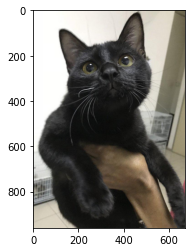

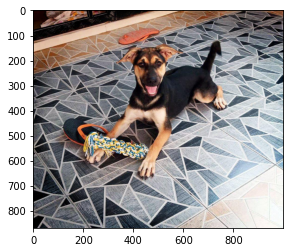

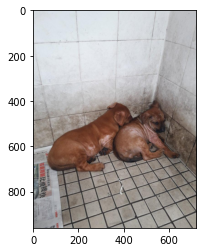

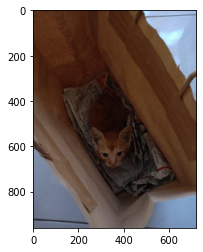

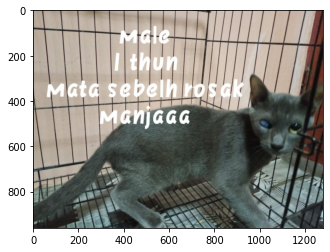

In [27]:
for path in df[df.norm_score == 0.3].path.values[:5]:
    image = cv2.imread(path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [28]:
import torchvision.transforms as T

In [29]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm

In [30]:
if 0:
    model = timm.create_model('efficientnet_b1', pretrained=True, num_classes=59)
    device = 'cuda:1'
    model.to(device)
    from fastai.vision.all import *
    dls = ImageDataLoaders.from_df(df, #pass in train DataFrame
                               #seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               #label_col='Breed1', #label is in the first column of the DataFrame
                               y_block=CategoryBlock, #The type of target
                               bs=32, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               #batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])
                                  ) #pass in batch_tfms
    preds = 0
    for i in tqdm(range(5)):
        model.load_state_dict(torch.load(f'models/model_breed_{i}.pth'))
        learn = Learner(dls, model).to_fp16()

        test_dl = dls.test_dl(df)
        _preds, _ = learn.get_preds(dl=test_dl)

        preds += _preds / 5

    df['breed_label'] = preds.argmax(axis=1).numpy()
    df['breed_prob'] = preds.max(axis=1).values.numpy()
    
    df[['path', 'breed_label', 'breed_prob']].to_csv('breed.csv', index=False)

In [31]:
#model = timm.create_model('resnet200d')

In [32]:
if 1:
    device = 'cuda:1'
    model.to(device)
    with torch.no_grad():
        list_label = []
        list_det = []
        for path in tqdm(df['path'].values):

            result = inference_detector(model, path)
            list_det.append(get_det_result(result))
            #image = cv2.imread(path)
            #list_label.append(image.shape)

            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255

            #image = cv2.resize(image, (240, 240))
            #image = np.moveaxis(image, -1, 0)
            #image = torch.tensor([image], dtype=torch.float32, device=device)
            #list_label.append(model(image).cpu().numpy()[0].argmax())

    #df['resnet_label'] = list_label
    #list_label = np.array(list_label)
    #df['img_h'] = list_label[:, 0]
    #df['img_w'] = list_label[:, 1]



  0%|          | 0/9912 [00:00<?, ?it/s]

In [49]:
list_label

[]

In [50]:
list_det = np.stack([d if len(d) == 6 else [np.nan] * 6 for d in list_det])
list_label = []
for path in tqdm(df['path'].values):
    list_label.append(cv2.imread(path).shape)
list_label = np.stack(list_label)
df['img_h'] = list_label[:, 1]
df['img_w'] = list_label[:, 0]

df['det_label'] = list_det[:, 0]
df['det_left'] = list_det[:, 1] / df['img_w']
df['det_top'] = list_det[:, 2] / df['img_h']
df['det_right'] = list_det[:, 3] / df['img_w']
df['det_bottom'] = list_det[:, 4] / df['img_h']
df['det_prob'] = list_det[:, 5]

  0%|          | 0/9912 [00:00<?, ?it/s]

In [51]:
df[['path', 'det_label', 'det_left', 'det_top', 'det_right', 'det_bottom', 'det_prob']]

,path,det_label,det_left,det_top,det_right,det_bottom,det_prob
0,../input/petfinder-pawpularity-score/train/eba...,17.0,0.005150,0.242811,0.401855,1.272841,0.972833
1,../input/petfinder-pawpularity-score/train/25e...,17.0,0.269992,0.090534,0.863412,0.878119,0.984916
2,../input/petfinder-pawpularity-score/train/654...,17.0,0.198597,0.075323,0.750000,1.042935,0.638664
3,../input/petfinder-pawpularity-score/train/472...,17.0,0.088668,0.028490,0.744878,0.965890,0.994252
4,../input/petfinder-pawpularity-score/train/7b7...,17.0,0.458188,0.009403,1.083303,0.729881,0.993708
...,...,...,...,...,...,...,...
9907,../input/petfinder-pawpularity-score/train/d9a...,16.0,0.077686,0.029050,0.515327,1.516820,0.975234
9908,../input/petfinder-pawpularity-score/train/c3a...,17.0,0.163721,0.000000,0.750000,1.295164,0.791172
9909,../input/petfinder-pawpularity-score/train/d9e...,16.0,0.049455,0.154705,0.621696,0.858619,0.845833
9910,../input/petfinder-pawpularity-score/train/971...,16.0,0.012919,0.024719,0.748872,1.197141,0.963928


In [53]:
df[['path', 'det_label', 'det_left', 'det_top', 'det_right', 'det_bottom', 'det_prob']].to_csv('objdet.csv', index=False)

In [34]:
df['isin'] = df['path'].isin(np.load('isin_prev.npy', allow_pickle=True))
df['isin'].mean()

0.153954802259887

In [35]:
COL_FEATURES = ['Blur', 
                #'Face', 
                #'Occlusion',
                'Eyes',
                #'Accessory',
               #'Group',
                #'Human',
                #'Near',
                #'Collage',
                #'Info',# 
                #'Action',
                'pred',
                #'isin'
                #'breed_label', 'breed_prob',
                #'img_h', 'img_w',
                #'det_label', 'det_left', 'det_top', 'det_right', 'det_bottom', 'det_prob'
               ]

#COL_FEATURES = COL_FEATURES[:7]

In [36]:
df[COL_FEATURES]

,Blur,Eyes,pred
0,1,0,0.354780
1,0,1,0.407235
2,0,0,0.317417
3,0,1,0.255778
4,0,1,0.293243
...,...,...,...
9907,0,1,0.421003
9908,0,1,0.545178
9909,0,1,0.293599
9910,0,1,0.391733


In [37]:
if df['Pawpularity'].values.min() == 0:
    df['Pawpularity'] += 1

In [38]:
def rmse(preds, train_data):
    labels = train_data.get_label()
    #import pdb;pdb.set_trace()
    loss = np.sqrt(((labels - preds.clip(0.01, 1)) ** 2).mean()) * 100
    
    #loss = np.sqrt(((labels - preds.reshape(-1, 100).argmax(axis=1)) ** 2).mean())
    return 'rmse', loss, False


def train(fold, param):
     
    X_train = df.loc[df['fold'] != fold, COL_FEATURES]
    y_train = df.loc[df['fold'] != fold, 'Pawpularity'].values  / 100
    
    X_valid = df.loc[df['fold'] == fold, COL_FEATURES]
    y_valid = df.loc[df['fold'] == fold, 'Pawpularity'].values  / 100
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
    
    model = lgb.train(param,
                      train_data,
                      valid_sets=valid_data,
                      early_stopping_rounds=50,
                      verbose_eval=100,
                      feval=rmse
                      )
    return model

In [39]:
all_params = {'objective': ['xentropy'],
             'verbosity': [-1],
             'boosting_type': ['gbdt'],
             # 'feature_pre_filter': False,
             # 'bagging_fraction': 1.0,
             'bagging_freq': [1],
             'num_iterations': [10000],
             'early_stopping_round': [10],
             'n_jobs': [16],
             'seed': [114],
             'metric':  ['None'],  # trial.suggest_categorical('metric', ['auc', 'binary_logloss', ]), #'auc',
             'learning_rate': [0.1],
              'lambda_l1': [0],
              'lambda_l2': [0],
              'min_child_samples': [15],
              'num_leaves': [3],
              'feature_fraction': [0.8],
              'min_gain_to_split': [0],
              #'num_class': [100]
             #'lambda_l1': trial.suggest_uniform('lambda_l1', 0, 10),
             #'lambda_l2': trial.suggest_uniform('lambda_l2', 0, 10),
             # 'num_leaves': trial.suggest_int('num_leaves', 7, 127),
             # 'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1),
             # 'min_child_samples': trial.suggest_int('min_child_samples', 5, 500),
             # 'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1),
             # 'feature_fraction_bynode': trial.suggest_uniform('feature_fraction_bynode', 0.5, 1),
             # 'min_gain_to_split': trial.suggest_uniform('min_gain_to_split', 0, 10),
             }

In [40]:
best_score = 1.0e10
best_param = None
for param in tqdm(ParameterGrid(all_params)):
    print(param)
    list_loss = []
    list_imp = []
    for fold in range(5):
        model = train(fold, param)
        sc = model.best_score['valid_0']['rmse']# * 100
        list_loss.append(sc)
        
        imp = pd.DataFrame(model.feature_importance(importance_type='gain'), columns=['imp'])
        imp['col'] = COL_FEATURES
        list_imp.append(imp.set_index('col'))
    sc = np.mean(list_loss)
    if sc < best_score:
        best_score = sc
        best_param = param

  0%|          | 0/1 [00:00<?, ?it/s]

{'bagging_freq': 1, 'boosting_type': 'gbdt', 'early_stopping_round': 10, 'feature_fraction': 0.8, 'lambda_l1': 0, 'lambda_l2': 0, 'learning_rate': 0.1, 'metric': 'None', 'min_child_samples': 15, 'min_gain_to_split': 0, 'n_jobs': 16, 'num_iterations': 10000, 'num_leaves': 3, 'objective': 'xentropy', 'seed': 114, 'verbosity': -1}
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[73]	valid_0's rmse: 17.5451
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[64]	valid_0's rmse: 17.5375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[87]	valid_0's rmse: 17.2004
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[49]	valid_0's rmse: 17.5165
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	valid_0's rmse: 17.5372


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [41]:
print(best_param)
print(best_score)

{'bagging_freq': 1, 'boosting_type': 'gbdt', 'early_stopping_round': 10, 'feature_fraction': 0.8, 'lambda_l1': 0, 'lambda_l2': 0, 'learning_rate': 0.1, 'metric': 'None', 'min_child_samples': 15, 'min_gain_to_split': 0, 'n_jobs': 16, 'num_iterations': 10000, 'num_leaves': 3, 'objective': 'xentropy', 'seed': 114, 'verbosity': -1}
17.46732744087626


In [42]:
with open('models/model_lgb_1215.pkl', 'wb') as f:
    pickle.dump(model, f, -1)

In [43]:
#imp = pd.DataFrame(model.feature_importance(importance_type='gain'), columns=['imp'])
#imp['col'] = COL_FEATURES
imp = sum(list_imp) / 5
imp.sort_values('imp', ascending=False)

,imp
col,
pred,2142.938521
Eyes,6.310749
Blur,4.259568
